# # Homework 2: Unsupervised representation learning

# Download data, install packages

In [23]:
# !wget https://github.com/jertubiana/jertubiana.github.io/raw/master/misc/MLCB_2023_HW2_Data.pkl.zip
# !unzip MLCB_2023_HW2_Data.pkl.zip
# !pip install "ipyvolume>=0.6.2" "ipyvue>=1.9.1"

# ## Load packages, load data

In [24]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

path = 'MLCB_2023_HW2_Data.pkl'
env = pickle.load(open(path, 'rb'))
Spikes, Time, Coordinates, Regions, Region_names = env['Spikes'], env['Time'], env['Coordinates'], env['Regions'], env[
    'Region names']

EOFError: Ran out of input

# ## Visualize a short section of the recording as raster plot

Text(0.5, 1.0, 'Spike raster plot')

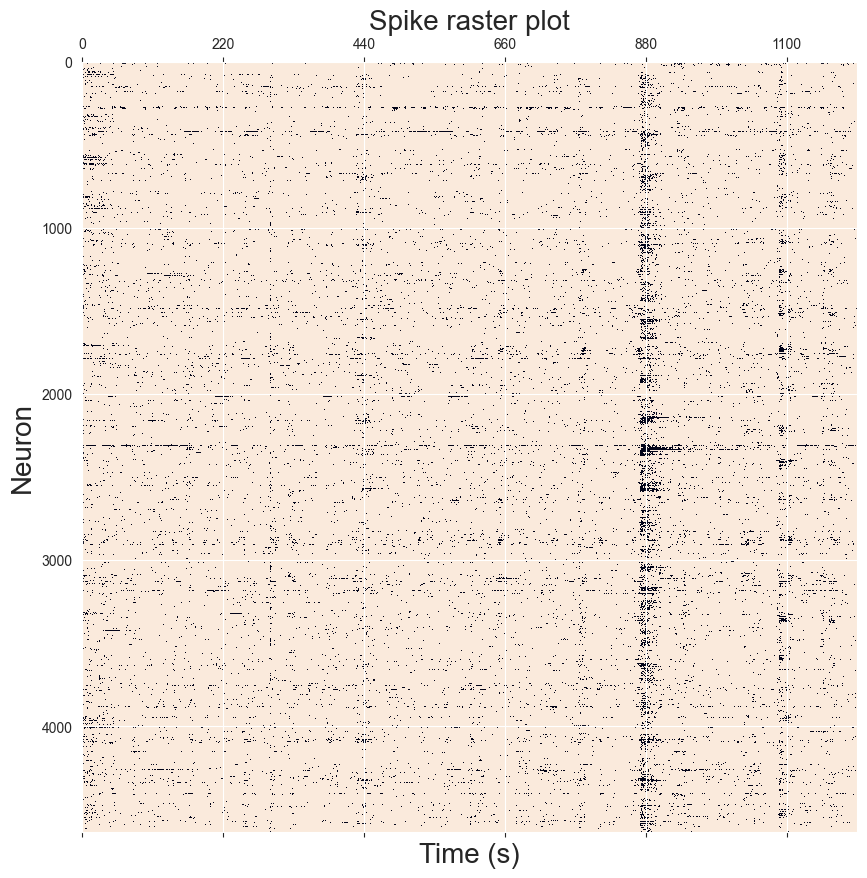

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.set_style("ticks")
ax.matshow(1 - Spikes.T, aspect='auto')
plt.xticks(np.arange(len(Time))[::1000], ['%.f' % t for t in Time[::1000]])
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Neuron', fontsize=20)
plt.title('Spike raster plot', fontsize=20)

# ## Visualize the coordinates the neurons, colored by the region labels.

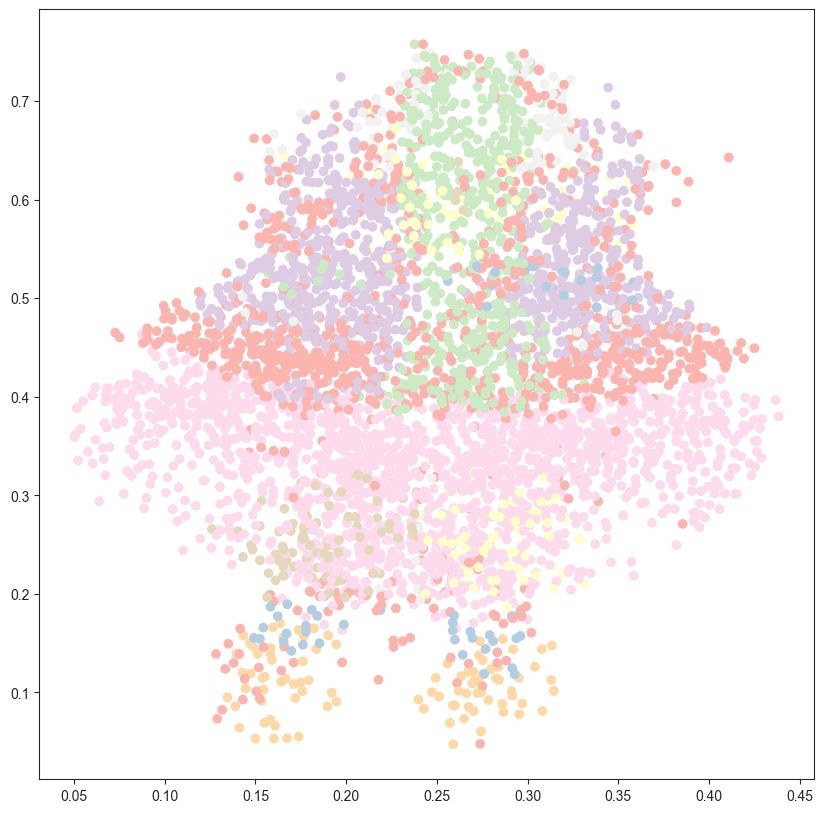

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(Coordinates[:, 0], Coordinates[:, 1], c=Regions, cmap='Pastel1')

# ## A 3D-visualization of the recording with ipyvolume
# This section does not run on Google Colab, but you can try it out on your local Python

In [27]:
import ipyvolume
from ipyvolume import datasets, embed, widgets, transferfunction, pylab


AttributeError: partially initialized module 'ipyvolume' has no attribute '_version' (most likely due to a circular import)

In [28]:
# import ipyvolume as ipv
# # from google.colab import output
# # output.enable_custom_widget_manager()
# 
# selected_time_frames = np.arange(100,200)
# 
# x = Coordinates[:,0][np.newaxis]
# y = Coordinates[:,1][np.newaxis]
# z = Coordinates[:,2][np.newaxis]
# 
# 
# 
# default_colors = np.array([
#     [0.,0.,0.,0.1],
#     [1,0,0,1.0]
# 
# ])
# color = default_colors[Spikes[selected_time_frames].astype(int)]
# size = 1
# 
# ipv.figure()
# s = ipv.scatter(x, y, z, color=color, size=size, marker="sphere")
# s.sequence_index = 0
# ipv.animation_control(s, interval=50)
# ipv.xlim( x.min(),x.max() )
# ipv.ylim( y.min(),y.max() )
# ipv.zlim( z.min(),z.max() )
# ipv.show()

# ## Subsampling the dataset to speed-up the analysis

In [34]:
np.random.seed(0)
active_neurons = (Spikes.mean(0) != 0)  # Remove all inactive neurons
random_subset = active_neurons & (np.random.rand(Spikes.shape[-1]) < 0.1)  # Keep only 10% of the neurons.
Spikes = Spikes[:, random_subset]
Coordinates = Coordinates[random_subset]
Regions = Regions[random_subset]


# Part II: Dataset Analysis (Representation learning) 

## Background:
Progress in functional brain imaging techniques enable the simultaneous recording of the activity of thousands of neurons simultaneously. 

An open question is how to relate the observed spontaneous activity to the underlying 
1) neuronal assemblies (sets of neurons involved in a specific task, e.g. sensory, motor or cognitive) 
1) connectome (set of synapses). 

Herein, we focus on a recording of spontaneous brain activity of a larval zebrafish. Activity was measured using genetically modified fish expressing a fluorescent calcium reporter and with light-sheet fluorescence microscopy.
 
This dataset was collected in the laboratory of Pr. Georges Debregeas (Reference: [elife](https://elifesciences.org/articles/83139)), and consists of:

1. A matrix $X_{ij}$ of binary spikes of format [Time x Neurons].
2. 3D coordinates of the neurons [Neurons x 3].
3. An integer brain region label for each neuron, assigned based on the morphology $ M_i $ [Neurons,].

Our goal is to recover, in an unsupervised manner, the morphological regions from the correlation structure of the data. A Google Colab Notebook with package installation, dataset download and visualizations is available from: [Colab Notebook](https://colab.research.google.com/drive/1qSQelSprDyMKF_uRQ6ihDZWWnfdF7nOB?usp=sharing)

 
### Low-dimensional embeddings: PCA vs t-SNE
 
We define a custom distance metric between two neurons as one minus the absolute value of the Pearson correlation coefficient:
$$
\[ D_{ij} = 1 - \left| \frac{ \text{Cov}(X_i, X_j) }{ \sqrt{ \text{Var}(X_i) \cdot \text{Var}(X_j) } } \right| \]
$$

1. Using the scikit-learn default implementations, calculate two-dimensional embeddings $ R_{PCA/t-SNE} $ of the data using 1) PCA and 2) t-SNE with a perplexity of 5, 10, 20, 50, 100. Visualize them using scatter plots, where the points are colored by the brain region.


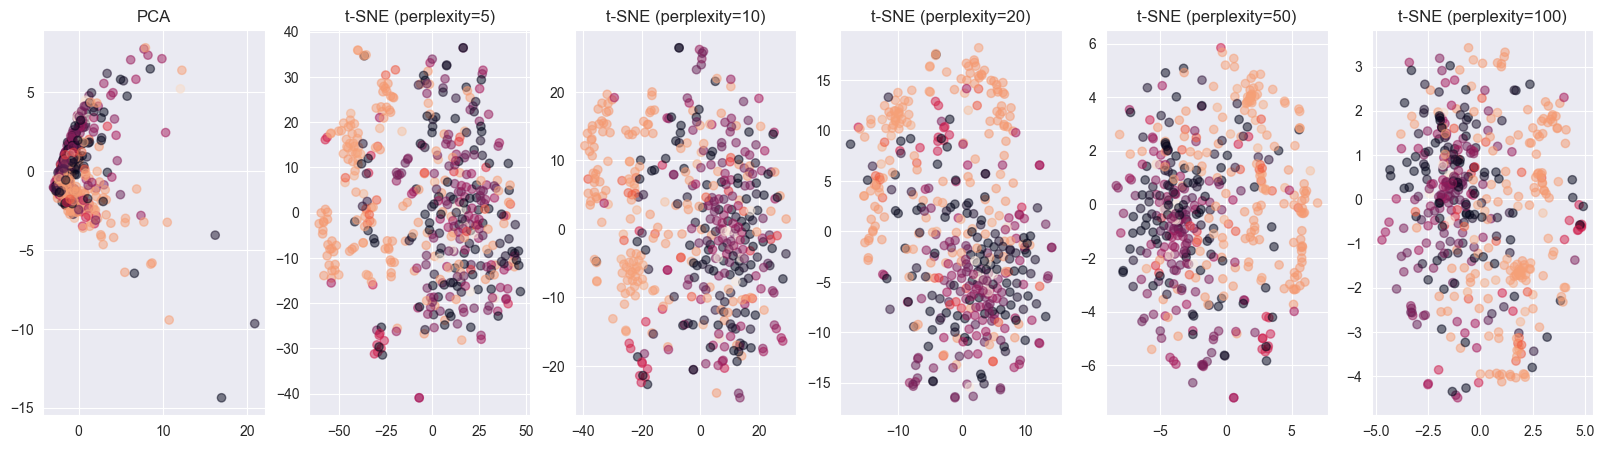

In [33]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Calculate the custom distance metric
from scipy.spatial.distance import pdist, squareform

def custom_distance(X):
    return 1 - np.abs(np.corrcoef(X, rowvar=False))

distance_matrix = custom_distance(Spikes)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(Spikes.T)

# Perform t-SNE with different perplexities
tsne_results = {}
perplexities = [5, 10, 20, 50, 100]
for perplexity in perplexities:
    tsne = TSNE(n_components=2, perplexity=perplexity, metric='precomputed', init='random')
    tsne_results[perplexity] = tsne.fit_transform(distance_matrix)

# Visualization
fig, axes = plt.subplots(1, len(perplexities) + 1, figsize=(20, 5))
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c=Regions, alpha=0.5)
axes[0].set_title('PCA')
for i, perplexity in enumerate(perplexities):
    axes[i + 1].scatter(tsne_results[perplexity][:, 0], tsne_results[perplexity][:, 1], c=Regions, alpha=0.5)
    axes[i + 1].set_title(f't-SNE (perplexity={perplexity})')
plt.show()


#### Which method qualitatively separates the regions in the most convincing way?

Answer: t-SNE with perplexity 20 separates the regions in the most convincing way. The regions are more clearly separated compared to PCA and other t-SNE perplexities.

# 2. **Preserving global data structure.** For each method, calculate the spearman correlation coefficient between the original dissimilarity matrix $ D_{ij} $ and the Euclidean distance matrix in the embedding: $ D_{ij}^{R} = || R_i - R_j || $. 
# 

In [ ]:
from scipy.stats import spearmanr
from sklearn.metrics import pairwise_distances

def calculate_spearman(original_dist, embedding):
    embedding_dist = pairwise_distances(embedding)
    return spearmanr(squareform(original_dist), squareform(embedding_dist)).correlation

pca_spearman = calculate_spearman(distance_matrix, pca_result)
tsne_spearmans = {perplexity: calculate_spearman(distance_matrix, tsne_result) for perplexity, tsne_result in tsne_results.items()}

print("Spearman correlation for PCA:", pca_spearman)
for perplexity, spearman_corr in tsne_spearmans.items():
    print(f"Spearman correlation for t-SNE (perplexity={perplexity}):", spearman_corr)


# 
# 3. **Preserving local data structure.** We define the K-nearest neighbors (K-NN) graph $ A_{ij} $ as:
# 
# $$
# 
# \[ A_{ij} = 
# \begin{cases} 
# 1 & \text{if } j \text{ is one of the K – nearest neighbors of } i, \text{ or vice versa} \\ 
# 0 & \text{otherwise} 
# \end{cases}
# \]
# $$
# 
# 
#    a) With K=50, calculate the K-NN graphs using the original $ D_{ij} $ and, for each method, $ D_{ij}^{R} $. They are denoted by $ A $ and $ A^{R} $, respectively.  
#    b) Calculate the fraction of edges in the original graph $ A $ that are preserved in $ A^{R} $. Conclude on which method best preserves the local neighborhoods?
# 

# 4. **Preserving morphology.** Using the same graphs $ A $ and $ A^{R} $, calculate the fraction of pairs of neighbors that belong to the same region:
# $$
# \[ f = \frac{\sum_{i,j} A_{i,j} \delta_{M_i, M_j}}{\sum_{i,j} A_{i,j}} \]
# $$
# Which method best preserves morphological similarity?

# 
# ## B. Feature extraction: PCA vs NMF.
# 
# 1. For each of the first two principal components, visualize the corresponding principal loadings (projection matrix) in space, using scatter plots and/or the ipyvolume visualization provided. Do they localize onto some of the morphological regions?

# 2. Using the scikit-learn’s implementation, apply Non-Negative Matrix Factorization with n_components=20 and visualize two components in space. Do they localize onto some of the morphological regions?

# 3. Repeat for n_components = 2, 5 and 50. How do the components change?
# 